# Summarize the results of K562 active learning starting conditions
Required inputs: all `performance.txt` files in `ModelFitting/K562/OneRound/` as output by `cnn_k562_classification_sampling.py`.

Outputs: `activeLearningK562StartingConditions_{AUPR,AUROC}.svg` performance measures of binary classifier after one round of entropy and random sampling, across many starting conditions.

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display

sys.path.insert(0, "src")
from mpra_tools import plot_utils, loaders

plot_utils.set_manuscript_params()

/ref/bclab/software/ryan/.conda/envs/active-learning/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
run_dir = os.path.join("ModelFitting", "K562", "OneRound")
n_folds = 10

In [3]:
performance = []
old_dir = os.getcwd()
os.chdir(run_dir)

for fold in range(1, n_folds + 1):
    os.chdir(str(fold))
    for train_init in os.listdir():
        os.chdir(train_init)
        expt_summary = loaders.load_data("performance.txt").reset_index(names="model")
        expt_summary["epochs"] = expt_summary["model"].apply(lambda x: loaders.load_data(os.path.join(x, "selene_sdk.train_model.validation.txt")).shape[0])
        splitter = expt_summary["model"].str.split("_")
        expt_summary["sampling"] = splitter.str[0]
        expt_summary["batch_size"] = splitter.str[1].astype(float)
        expt_summary["initial_data"] = int(train_init)
        expt_summary["fold"] = int(fold)
        performance.append(expt_summary)
        os.chdir("../")
    os.chdir("../")
    
os.chdir(old_dir)
performance = pd.concat(performance, ignore_index=True)
# To make comparisons easier, copy the performance of the full models when initial is 5000 to be the same but with initial at 4000 and 3000
full_models = performance[performance["sampling"] == "full"].copy()
for i in [3000, 4000]:
    full_models["initial_data"] = i
    performance = pd.concat([performance, full_models], ignore_index=True)
 
# This will help with display
performance["model"] = performance["model"].astype("category").cat.set_categories(
    ["initial", "random_1000", "entropy_1000", "random_3000", "entropy_3000", "random_5000", "entropy_5000", "full"], ordered=True
)

performance = performance.rename(columns={
    "roc_auc_score": "AUROC",
    "average_precision_score": "AUPR",
    "weighted_f1": "wF1"
})

loaders.write_data(performance, os.path.join(run_dir, "performance_summary.txt"))

In [4]:
# Find the entropy-sampled model that does the best based on AUPR
performance[performance["sampling"] == "entropy"].sort_values(by="AUPR", ascending=False)

,model,AUROC,AUPR,wF1,epochs,sampling,batch_size,initial_data,fold
89,entropy_5000,0.855420,0.787581,0.801458,99,entropy,5000.0,5000,5
177,entropy_5000,0.848587,0.771966,0.795174,60,entropy,5000.0,5000,9
97,entropy_5000,0.844982,0.768372,0.792526,85,entropy,5000.0,4000,5
104,entropy_5000,0.839288,0.762699,0.782684,73,entropy,5000.0,3000,5
90,entropy_3000,0.831778,0.751067,0.752610,71,entropy,3000.0,5000,5
...,...,...,...,...,...,...,...,...,...
62,entropy_1000,0.779669,0.604003,0.755965,99,entropy,1000.0,3000,3
172,entropy_1000,0.755539,0.582640,0.743009,99,entropy,1000.0,3000,8
106,entropy_1000,0.627016,0.479783,0.538264,76,entropy,1000.0,3000,5
187,entropy_1000,0.645435,0.458799,0.556846,99,entropy,1000.0,4000,9


Intermediate figure to check the performance of the initial model and different starting conditions vs. a model trained on all the data.

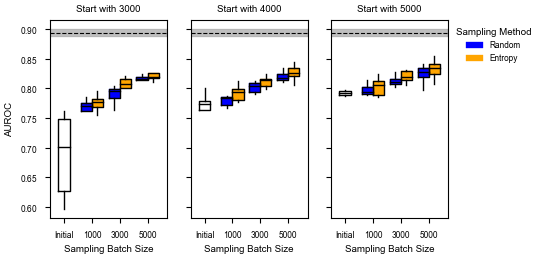

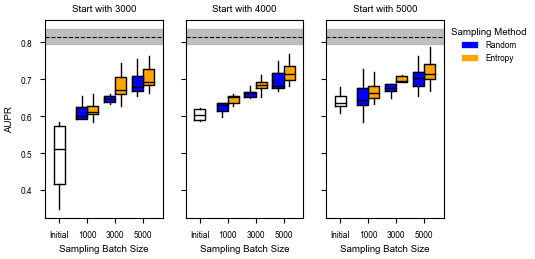

In [5]:
for metric in ["AUROC", "AUPR"]:
    data_grouper = performance.groupby("initial_data")
    fig, ax_list = plt.subplots(
        ncols=len(data_grouper),
        sharey=True,
        figsize=plot_utils.get_figsize(frac=0.75, aspect=0.5)
    )

    for ax, (initial_data, df) in zip(ax_list, data_grouper):
        model_grouper = df.groupby("model")
        full_model = model_grouper.get_group("full")

        names, data = zip(*[(n, d[metric]) for n, d in model_grouper if n != "full"])
        width = 0.4
        offset = width / 2
        positions = np.array([1, 2 - offset, 2 + offset, 3 - offset, 3 + offset, 4 - offset, 4 + offset])
        colors = ["white", "blue", "orange", "blue", "orange", "blue", "orange"]

        bplot = ax.boxplot(
            data,
            widths=width,
            positions=positions
        )

        # https://github.com/proplot-dev/proplot/issues/217
        for patch, color in zip(bplot["boxes"], colors):
            ax.add_artist(mpatches.PathPatch(patch.get_path(), color=color))

        full_mean = full_model[metric].mean()
        full_std = full_model[metric].std()
        ax.axhline(full_mean, color="k", linestyle="--")
        ax.axhspan(full_mean - full_std, full_mean + full_std, color="k", alpha=0.25)

        ax.set_xticks([1, 2, 3, 4], ["Initial", "1000", "3000", "5000"])
        ax.set_xlabel("Sampling Batch Size")
        ax.set_title(f"Start with {initial_data}")

    ax_list[0].set_ylabel(metric)
    ax_list[-1].legend(
        loc="upper left",
        bbox_to_anchor=(1, 1),
        handles=[
            mpatches.Patch(color="blue", label="Random"),
            mpatches.Patch(color="orange", label="Entropy")
        ],
        title="Sampling Method",
        frameon=False,
    )

Replot as the difference in relative improvement: (entropy - random) / initial.

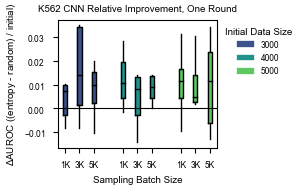

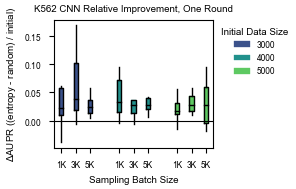

In [6]:
for metric in ["AUROC", "AUPR"]:
    model_vs_starting_conditions = pd.pivot(
        performance,
        index=["initial_data", "fold"],
        columns=["sampling", "batch_size"],
        values=metric
    )

    # Don't need the full model here
    model_vs_starting_conditions = model_vs_starting_conditions.drop(columns="full", level="sampling")

    # Divide all performance measures by the initial performance of the corresponding fold
    relative_improvement = model_vs_starting_conditions.divide(
        model_vs_starting_conditions["initial"].squeeze(),
        axis=0
    )
    relative_improvement = relative_improvement.drop(columns="initial", level="sampling")

    difference_in_improvement = relative_improvement["entropy"] - relative_improvement["random"]
    difference_in_improvement.columns = difference_in_improvement.columns.astype(int)
    difference_in_improvement = difference_in_improvement.sort_index(axis=1)

    fig, ax = plt.subplots(figsize=plot_utils.get_figsize(frac=0.3, aspect=0.81))
    colors = plot_utils.set_color([0.25, 0.5, 0.75])
    last = -2
    xticks = np.array([])
    xticklabels = []
    handles = []

    for c, (initial_size, data) in zip(colors, difference_in_improvement.groupby("initial_data")):
        xaxis = last + 2 + np.arange(data.shape[1])
        xticks = np.append(xticks, xaxis)
        xticklabels += data.columns.map(lambda x: str(int(x/1000)) + "K").tolist()

        bplot = ax.boxplot(
            data.values.T.tolist(),
            positions=xaxis
        )

        handles.append(mpatches.Patch(color=c, label=initial_size))
        for patch in bplot["boxes"]:
            ax.add_artist(mpatches.PathPatch(patch.get_path(), color=c))

        last = xaxis[-1]

    ax.set_xticks(xticks, xticklabels)
    ax.set_xlabel("Sampling Batch Size")
    ax.set_ylabel(rf"$\Delta${metric} ((entropy - random) / initial)")
    ax.axhline(0, color="k")
    ax.legend(
        loc="upper left",
        bbox_to_anchor=(1, 1),
        frameon=False,
        handles=handles,
        title="Initial Data Size",
    )
    ax.set_title("K562 CNN Relative Improvement, One Round")
    plot_utils.save_fig(fig, os.path.join("Figures", f"activeLearningK562StartingConditions_{metric}"))